**Step 1: Import Libraries and Load Data**

In [29]:
# Import all required libraries
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import kagglehub
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import warnings
warnings.filterwarnings('ignore')

# Check versions
print(f"TensorFlow version: {tf.__version__}")

# Download the dataset
print("Downloading dataset...")
path = kagglehub.dataset_download("lakshmi25npathi/imdb-dataset-of-50k-movie-reviews")
print(f"Path to dataset files: {path}")

# Load the dataset
df = pd.read_csv(path + '/IMDB Dataset.csv')
print(f"Dataset shape: {df.shape}")
print("\nFirst few rows:")
print(df.head())
print("\nSentiment distribution:")
print(df['sentiment'].value_counts())

TensorFlow version: 2.19.0
Using Colab cache for faster access to the 'imdb-dataset-of-50k-movie-reviews' dataset.
Path to dataset files: /kaggle/input/imdb-dataset-of-50k-movie-reviews
Dataset shape: (50000, 2)

First few rows:
                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive

Sentiment distribution:
sentiment
positive    25000
negative    25000
Name: count, dtype: int64


**Step 2: Data Preprocessing**

In [30]:
# Convert sentiments to numerical labels
label_encoder = LabelEncoder()
df['sentiment_label'] = label_encoder.fit_transform(df['sentiment'])

print("Label mapping:")
print(dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))

# Enhanced text cleaning
def clean_text(text):
    if isinstance(text, str):
        text = text.lower()
        text = text.replace('<br />', ' ')  # Remove HTML tags
        text = text.replace('\n', ' ')      # Remove newlines
        text = text.replace('\t', ' ')      # Remove tabs
        # Remove special characters but keep basic punctuation
        text = ''.join(char for char in text if char.isalnum() or char in ' .,!?')
        # Remove extra spaces
        text = ' '.join(text.split())
    return text

df['cleaned_review'] = df['review'].apply(clean_text)

print(f"Sample cleaned review: {df['cleaned_review'].iloc[0][:200]}...")

Label mapping:
{'negative': np.int64(0), 'positive': np.int64(1)}
Sample cleaned review: one of the other reviewers has mentioned that after watching just 1 oz episode youll be hooked. they are right, as this is exactly what happened with me. the first thing that struck me about oz was it...


**Step 3: Split the Dataset**

In [31]:
# Split the data into train, validation, and test sets
X = df['cleaned_review']
y = df['sentiment_label']

# First split: 80% train, 20% temp
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Second split: 50% validation, 50% test (from the 20%)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

Training set: 40000 samples
Validation set: 5000 samples
Test set: 5000 samples


**Step 4: Tokenization and Sequence Preparation**

In [32]:
# Tokenize the text
vocab_size = 20000  # Increased vocabulary for CNN
max_length = 300    # Slightly longer sequences for CNN
oov_token = "<OOV>"

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_token, filters='')
tokenizer.fit_on_texts(X_train)

# Convert texts to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Pad sequences to ensure uniform length
X_train_pad = pad_sequences(X_train_seq, maxlen=max_length, padding='post', truncating='post')
X_val_pad = pad_sequences(X_val_seq, maxlen=max_length, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_length, padding='post', truncating='post')

print(f"Training sequences shape: {X_train_pad.shape}")
print(f"Validation sequences shape: {X_val_pad.shape}")
print(f"Test sequences shape: {X_test_pad.shape}")
print(f"Vocabulary size used: {min(vocab_size, len(tokenizer.word_index))}")

Training sequences shape: (40000, 300)
Validation sequences shape: (5000, 300)
Test sequences shape: (5000, 300)
Vocabulary size used: 20000


**Step 5: Build the CNN Model**

In [33]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, BatchNormalization, Dropout, GlobalMaxPooling1D, Dense
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.optimizers import Adam

def create_cnn_model(vocab_size, max_length, embedding_dim=100, num_filters=128):
    model = Sequential([
        # Embedding layer - FIXED: Remove input_length to avoid deprecation warning
        Embedding(
            input_dim=vocab_size,
            output_dim=embedding_dim,
            name='embedding_layer'
        ),

        # First Conv1D layer
        Conv1D(
            filters=num_filters,
            kernel_size=5,
            activation='relu',
            padding='same',
            kernel_regularizer=l2(0.001),
            name='conv1d_layer_1'
        ),
        BatchNormalization(name='batchnorm_1'),
        Dropout(0.3, name='dropout_1'),

        # Second Conv1D layer
        Conv1D(
            filters=num_filters//2,
            kernel_size=4,
            activation='relu',
            padding='same',
            kernel_regularizer=l2(0.001),
            name='conv1d_layer_2'
        ),
        BatchNormalization(name='batchnorm_2'),
        Dropout(0.3, name='dropout_2'),

        # Third Conv1D layer
        Conv1D(
            filters=num_filters//4,
            kernel_size=3,
            activation='relu',
            padding='same',
            kernel_regularizer=l2(0.001),
            name='conv1d_layer_3'
        ),
        BatchNormalization(name='batchnorm_3'),

        # Global Max Pooling - FIXED: Corrected spelling
        GlobalMaxPooling1D(name='global_max_pooling'),

        # Dense layers
        Dense(64, activation='relu', kernel_regularizer=l2(0.001), name='dense_1'),
        BatchNormalization(name='batchnorm_4'),
        Dropout(0.5, name='dropout_3'),

        Dense(32, activation='relu', kernel_regularizer=l2(0.001), name='dense_2'),
        Dropout(0.3, name='dropout_4'),

        # Output layer
        Dense(1, activation='sigmoid', name='output_layer')
    ])

    return model

# Create the CNN model
embedding_dim = 100
num_filters = 128

print("Creating CNN model...")
model = create_cnn_model(vocab_size, max_length, embedding_dim, num_filters)

# CRITICAL FIX: Build the model with input shape before compiling
model.build(input_shape=(None, max_length))

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Display model architecture
print("CNN Model Architecture:")
model.summary()

Creating CNN model...
CNN Model Architecture:


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_layer (Embedding)     │ (None, 300, 100)       │     2,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_layer_1 (Conv1D)         │ (None, 300, 128)       │        64,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnorm_1                     │ (None, 300, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 300, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_layer_2 (Conv1D)         │ (None, 300, 64)        │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnorm_2                     │ (None, 300, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 300, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_layer_3 (Conv1D)         │ (None, 300, 32)        │         6,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnorm_3                     │ (None, 300, 32)        │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling              │ (None, 32)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnorm_4                     │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,108,513 (8.04 MB)

 Trainable params: 2,107,937 (8.04 MB)

 Non-trainable params: 576 (2.25 KB)

**Step 6: Train the CNN Model**

In [34]:
# Set up callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=0.00001,
    verbose=1
)

print("Starting CNN model training...")

# Train the model
history = model.fit(
    X_train_pad,
    y_train,
    epochs=5,
    batch_size=64,  # Larger batch size for CNN
    validation_data=(X_val_pad, y_val),
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

print("CNN training completed!")

Starting CNN model training...
Epoch 1/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 248s 390ms/step - accuracy: 0.5049 - loss: 1.1070 - val_accuracy: 0.5252 - val_loss: 1.1167 - learning_rate: 0.0010
Epoch 2/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 257s 383ms/step - accuracy: 0.7261 - loss: 0.8082 - val_accuracy: 0.8330 - val_loss: 0.6049 - learning_rate: 0.0010
Epoch 3/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 242s 388ms/step - accuracy: 0.8816 - loss: 0.5241 - val_accuracy: 0.8534 - val_loss: 0.5290 - learning_rate: 0.0010
Epoch 4/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 258s 382ms/step - accuracy: 0.9190 - loss: 0.3973 - val_accuracy: 0.8664 - val_loss: 0.4611 - learning_rate: 0.0010
Epoch 5/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 260s 380ms/step - accuracy: 0.9400 - loss: 0.3090 - val_accuracy: 0.8694 - val_loss: 0.4390 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 5.
CNN training completed!


**Step 7: Evaluate the CNN Model**

Test Loss: 0.4454
Test Accuracy: 0.8656
F1-Score: 0.8729
Precision: 0.8278
Recall: 0.9232

Classification Report:
              precision    recall  f1-score   support

    negative       0.91      0.81      0.86      2500
    positive       0.83      0.92      0.87      2500

    accuracy                           0.87      5000
   macro avg       0.87      0.87      0.87      5000
weighted avg       0.87      0.87      0.87      5000


Overall Test Accuracy: 0.8656


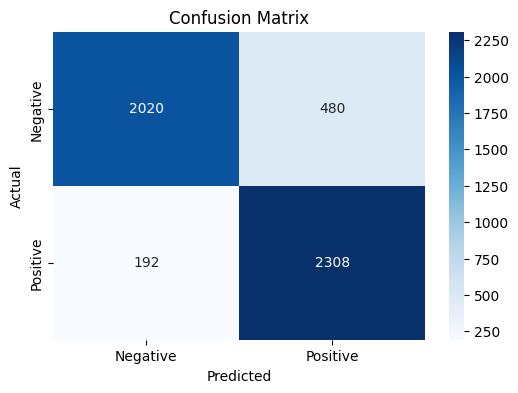

In [35]:
# Evaluate on test set
test_loss, test_accuracy = model.evaluate(X_test_pad, y_test, verbose=0)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Make predictions
y_pred_proba = model.predict(X_test_pad, verbose=0)
y_pred = (y_pred_proba > 0.5).astype(int).flatten()

# Additional metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate F1-Score, Precision, and Recall
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print(f'F1-Score: {f1:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

print(f"\nOverall Test Accuracy: {accuracy_score(y_test, y_pred):.4f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix as heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

**Step 8: Plot Training History**

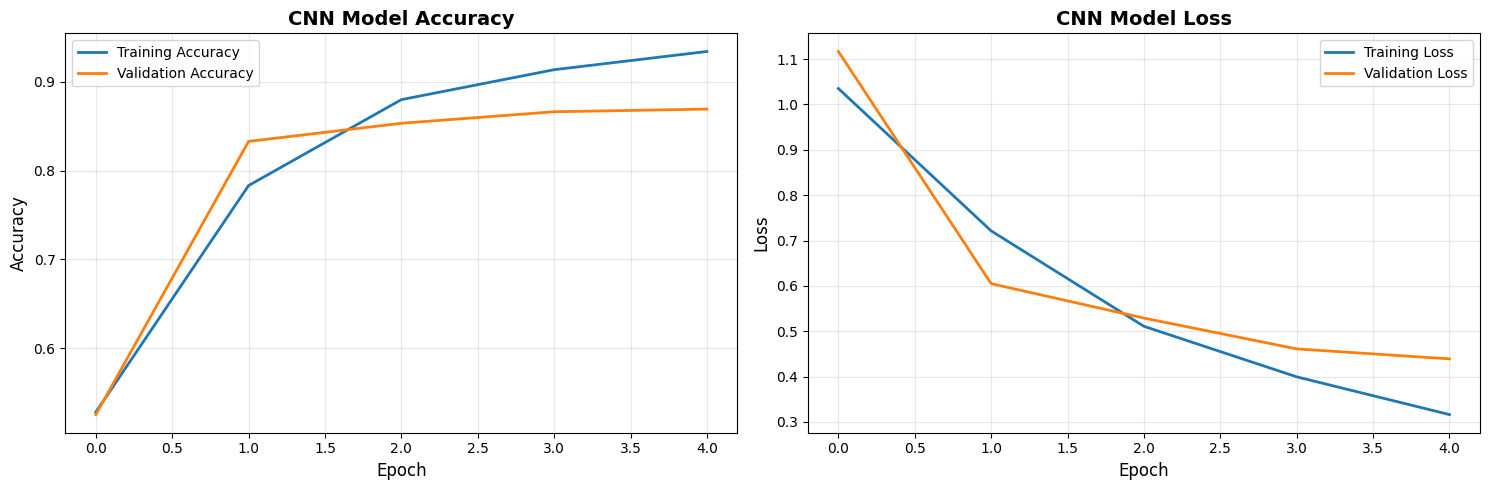


Final Training Accuracy: 0.9343
Final Validation Accuracy: 0.8694
Final Test Accuracy: 0.8656


In [36]:
def plot_cnn_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Plot accuracy
    ax1.plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
    ax1.set_title('CNN Model Accuracy', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Epoch', fontsize=12)
    ax1.set_ylabel('Accuracy', fontsize=12)
    ax1.legend(fontsize=10)
    ax1.grid(True, alpha=0.3)

    # Plot loss
    ax2.plot(history.history['loss'], label='Training Loss', linewidth=2)
    ax2.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
    ax2.set_title('CNN Model Loss', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Epoch', fontsize=12)
    ax2.set_ylabel('Loss', fontsize=12)
    ax2.legend(fontsize=10)
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

plot_cnn_training_history(history)

# Print final metrics
final_train_accuracy = history.history['accuracy'][-1]
final_val_accuracy = history.history['val_accuracy'][-1]
print(f"\nFinal Training Accuracy: {final_train_accuracy:.4f}")
print(f"Final Validation Accuracy: {final_val_accuracy:.4f}")
print(f"Final Test Accuracy: {test_accuracy:.4f}")

**Step 9: Save the Model and Make Predictions**

In [37]:
# Save the trained CNN model
model.save('sentiment_analysis_cnn_model.h5')
print("CNN Model saved as 'sentiment_analysis_cnn_model.h5'")

# Save the tokenizer
import pickle
with open('cnn_tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)
print("Tokenizer saved as 'cnn_tokenizer.pkl'")

# Function for predicting new reviews with CNN
def predict_sentiment_cnn(text, model, tokenizer, max_length=300):
    """
    Predict sentiment for a new review using CNN model
    """
    # Clean the text
    cleaned_text = clean_text(text)

    # Convert to sequence and pad
    sequence = tokenizer.texts_to_sequences([cleaned_text])
    padded_sequence = pad_sequences(sequence, maxlen=max_length, padding='post', truncating='post')

    # Make prediction
    prediction = model.predict(padded_sequence, verbose=0)[0][0]
    sentiment = 'positive' if prediction > 0.5 else 'negative'
    confidence = prediction if prediction > 0.5 else 1 - prediction

    return sentiment, confidence, prediction

# Test the prediction function
sample_reviews = [
    "One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fact that it goes where other shows wouldn't dare. Forget pretty pictures painted for mainstream audiences, forget charm, forget romance...OZ doesn't mess around. The first episode I ever saw struck me as so nasty it was surreal, I couldn't say I was ready for it, but as I watched more, I developed a taste for Oz, and got accustomed to the high levels of graphic violence. Not just violence, but injustice (crooked guards who'll be sold out for a nickel, inmates who'll kill on order and get away with it, well mannered, middle class inmates being turned into prison bitches due to their lack of street skills or prison experience) Watching Oz, you may become comfortable with what is uncomfortable viewing....thats if you can get in touch with your darker side.",
    "The plot is about the death of little children. Hopper is the one who has to investigate the killings. During the movie it appears that he has some troubles with his daughter. In the end the serial killer get caught. That's it. But before you find out who dunnit, you have to see some terrible acting by all of the actors. It is unbelievable how bad these actors are, including Hopper. I could go on like this but that to much of a waste of my time. Just don't watch the movie. I've warned you.",
    "Trinity. we see his search which features other PIs, only one who he meets, who has seemingly gone mad from his own experience trying to track Trinity down. eventually he makes contact with Trinity who he assumes to be a man of course - told in the narrative and something that firmly puts us in his own perspective despite what we already know - on a hacker chat-room, and solves a riddle which forces him in a hurry to catch a train. he forgets his hat but his faithful cat throws it to him in a moment of ludicrousness so absurd it's hilarious.<br /><br />he meets her on the train but the ruse is thereby revealed when agents attack; the agents were using him to get to Trinity and Trinity was trying to free the PIs sent after her, which he doesn't know of course, and which isn't explicitly stated in the animation itself, something common to film noir titles, which often hint at plenty of interesting back-story, subplots, developments etc. but don't show you more then the core story and a limited point of view to create an extra air of mystery and intrigue.<br /><br />almost everything in this short is in black and white, the music is reminiscent of film noir and the offbeat, old fashioned yet dedicated detective is the perfect protagonist for a film noir title. the trivia section of this title's entry on IMDb also helpfully presents a few references this title makes to hardboiled literature, something it also borrows heavily from, a genre of mysteries for detectives, gangsters etc. who engage in challenging conflicts readily and often. animated aptly by Studio 4Â°C and directed by Shinichiro Watanabe, it is an enjoyable variant on the usual matrix story.",
    "No one expects the Star Trek movies to be high art, but the fans do expect a movie that is as good as some of the best episodes. Unfortunately, this movie had a muddled, implausible plot that just left me cringing - this is by far the worst of the nine (so far) movies. Even the chance to watch the well known characters interact in another movie can't save this movie - including the goofy scenes with Kirk, Spock and McCoy at Yosemite.<br /><br />I would say this movie is not worth a rental, and hardly worth watching, however for the True Fan who needs to see all the movies, renting this movie is about the only way you'll see it - even the cable channels avoid this movie.",
    "Madharaasi marks a significant departure for Sivakarthikeyan, who steps into a serious, action-packed role under the direction of A.R. Murugadoss. The film, released on September 5, 2025, has garnered mixed reactions from audiences and critics alike."
]

print("\nTesting CNN predictions on sample reviews:")
print("=" * 60)
for i, review in enumerate(sample_reviews, 1):
    sentiment, confidence, score = predict_sentiment_cnn(review, model, tokenizer)
    print(f"\nReview {i}:")
    print(f"Text: {review[:100]}...")
    print(f"Predicted sentiment: {sentiment.upper()}")
    print(f"Confidence: {confidence:.4f}")
    print(f"Raw score: {score:.4f}")
    print("-" * 50)

CNN Model saved as 'sentiment_analysis_cnn_model.h5'
Tokenizer saved as 'cnn_tokenizer.pkl'

Testing CNN predictions on sample reviews:

Review 1:
Text: One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. The...
Predicted sentiment: POSITIVE
Confidence: 0.9907
Raw score: 0.9907
--------------------------------------------------

Review 2:
Text: The plot is about the death of little children. Hopper is the one who has to investigate the killing...
Predicted sentiment: NEGATIVE
Confidence: 0.9584
Raw score: 0.0416
--------------------------------------------------

Review 3:
Text: Trinity. we see his search which features other PIs, only one who he meets, who has seemingly gone m...
Predicted sentiment: POSITIVE
Confidence: 0.9246
Raw score: 0.9246
--------------------------------------------------

Review 4:
Text: No one expects the Star Trek movies to be high art, but the fans do expect a movie that is as good a...
Predicted sentiment: NEGAT